# Analysis by year

### Primary research questions:

These results presented in this notebook the following questions

4. How have metrics changed in over the three years of the study?

> Specifically we look at the number of shared models split into general health and Covid-19 subgroups.  We also analyse how the number of shared models as a proportion of the literature.

## 1. Imports 

### 1.1. Standard Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# set up plot style as ggplot
plt.style.use('ggplot')

## 1.2 Imports from preprocessing module

In [2]:
# function for loading full dataset
from preprocessing import load_clean_dataset

## 2. Constants

In [3]:
FILE_NAME = 'https://raw.githubusercontent.com/TomMonks/' \
    + 'des_sharing_lit_review/main/data/share_sim_data_extract.zip'

RG_LABEL = 'reporting_guidelines_mention'
NONE = 'None'
WIDTH = 0.5

## 3. Functions

### 3.1. Functions to create summary statistics

Two functions are used together in order to generate the high level results by year. 

* `high_level_metrics` - takes a subgroup of the dataset and generates summary statistics and counts
* `analysis_by_year` - loop through the years passing each to `high_levle_metrics` and concatenates datasets at the end.

In [4]:
def high_level_metrics(df, name='None'):
    '''A simple high level summary of the review.
    
    Returns a dict containing simple high level counts
    and percentages in the data#
    
    Params:
    -------
    df: pd.DataFrame 
        A cleaned dataset.  Could be overall or subgroups/categories
        
    Returns:
    --------
        dict 
    '''
    results = {}
    included = df[df['study_included'] == 1]
    available = included[included['model_code_available'] == 1]
    results['n_included'] = len(included[included['study_included'] == 1])
    results['n_foss'] = len(included[included['foss_sim'] == '1'])
    results['n_covid'] = len(included[included['covid'] == 1])
    results['n_avail'] = len(included[included['model_code_available'] == 1])
    results['n_foss_avail'] = len(available[available['foss_sim'] == '1'])
    results['n_covid_avail'] = len(available[available['covid'] == 1])
    results['per_foss'] = results['n_foss'] / results['n_included']
    results['per_covid'] = results['n_covid'] / results['n_included']
    results['per_avail'] = results['n_avail'] / results['n_included']
    results['per_foss_avail'] = results['n_foss_avail'] / results['n_foss']
    results['per_covid_avail'] = results['n_covid_avail'] / results['n_covid']
    results['reporting_guide'] = \
        len(included[included['reporting_guidelines_mention'] != 'None'])
    results['per_reporting_guide'] = \
        results['reporting_guide'] / results['n_included']
    return pd.Series(results, name=name)

In [5]:
def analysis_by_year(df_clean, decimals=4):
    '''
    Conducts a high level analysis by year of publication
    2019-2022
    
    Params:
    -------
    df_clean: pd.DataFrame
        Assumes a cleaned version of the dataset.
    
    Returns: 
    -------
    pd.DataFrame
        Containing the result summary
        
    '''
    overall_results = high_level_metrics(df_clean, 'overall')
    year_results = []
    years = df_clean['pub_yr'].unique().tolist()
    for year in years:
        subset = df_clean[df_clean['pub_yr'] == year]
        year_results.append(high_level_metrics(subset, name=str(year)))
    year_results = [overall_results] + year_results
    year_results = pd.DataFrame(year_results).T.round(decimals)
    return year_results[sorted(year_results.columns.tolist())]

### 3.2 Functions to plot results

* `plot_sharing_by_year` - plot with 2 subfigures. The top subfigure is a stacked barchart of general health models + covid-19 models that have been shared by year of publication.  The lower subfigure presents yearly results as a percentage of total papers included in the study.

In [ ]:
def plot_sharing_by_year(n_general_models, n_covid_models, 
                         per_models, xlabels, width=WIDTH, grid=True,
                         figsize=(6, 5)):
    '''
    Plot the number of models shared by year of publication (in citation).
    
    In this function we split models into two subgroups: covid and non-covid
    Non-covid models are refered to as 'general health models'
    
    The function creates a figure with two subplots.  
    
    Subplot 1: A stacked barchart of general health models (non covid) 
    + covid-19 models that have been shared by year of publication.  A legend is
    provided to distinguish between general and covid models.
    
    Subplot 2: A bar chart expressing the total number of shared models as a 
    percentage of the number of included studies.
    
    Params:
    -------
    n_general_models: pd.DataFrame
        Count of non covid-19 models that have been shared by year of pub.
        
    n_covid_models: pd.DataFrame
         Count of covid-19 models that have been shared by year of pub.
         
    per_models: pd.DataFrame
        Percent of total studies included that have been shared by year of pub.
        
    xlabel: pd.DataFrame:
        The years that represent the x-axis
        
    width: float, optional (default=WIDTH)
        A parameter to manipulated the width of the bars (applies to both plots)
        
    grid: bool, optional (default=True)
        Display grid lines (applies to both subplots)
        
    figsize: tuple(int, int), optional (default=(6,5)
        The size of the figure.
        
    
    
    
    
    '''
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize)

    # include x, y grid 
    if grid:
        ax1.grid(ls='--', axis='y')
        ax2.grid(ls='--', axis='y')
    
    # plot one: stacked bar chart.  general health + covid models
    y1 = ax1.bar(xlabels, n_general_models, 
                label='General Health', width=width)

    y2 = ax1.bar(xlabels, n_covid_models,
               label='Covid-19', bottom=n_general_models, width=width)

    _ = ax1.set_ylabel('Shared Models')
    _ = ax1.legend(ncols=1, loc='upper right', fontsize=8)
    
    # force integer values on y axis
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

    # include x, y grid 
    if grid:
        ax1.grid(ls='--', axis='y')
        ax2.grid(ls='--', axis='y')
        
    ax1.bar_label(y2)

    # set size of x, y ticks
    ax1.tick_params(axis='both', labelsize=9)
    ax2.tick_params(axis='both', labelsize=9)

    # plot 2: percentage available by year
    _ = ax2.bar(xlabels, per_models, label='All models', 
                width=width, color='green')

    _ = ax2.set_ylabel('Percent of literature')
    
    return fig, (ax1, ax2)

## 4. Read in data

In [6]:
clean = load_clean_dataset(FILE_NAME)

## 5. Results

### 5.1 Overall summary table

In [7]:
# overall
year_summary = analysis_by_year(clean)
year_summary

,2019,2020,2021,2022,overall
n_included,104.0000,113.0000,124.0000,82.0000,423.0000
n_foss,15.0000,17.0000,29.0000,19.0000,80.0000
n_covid,1.0000,9.0000,30.0000,12.0000,52.0000
n_avail,5.0000,11.0000,14.0000,9.0000,39.0000
n_foss_avail,5.0000,5.0000,9.0000,5.0000,24.0000
n_covid_avail,0.0000,4.0000,10.0000,0.0000,14.0000
per_foss,0.1442,0.1504,0.2339,0.2317,0.1891
per_covid,0.0096,0.0796,0.2419,0.1463,0.1229
per_avail,0.0481,0.0973,0.1129,0.1098,0.0922
per_foss_avail,0.3333,0.2941,0.3103,0.2632,0.3000


### 5.3. Annual n and percentage figure

In [8]:
# annual figures excluding covid models
non_covid = year_summary.T['n_avail'] - year_summary.T['n_covid_avail']
non_covid

2019        5.0
2020        7.0
2021        4.0
2022        9.0
overall    25.0
dtype: float64

In [9]:
# no. covid models not available = no. covid models - no. avaiable covid models
n_not_avail_covid = year_summary.T['n_covid'] - year_summary.T['n_covid_avail']
n_not_avail_covid

2019        1.0
2020        5.0
2021       20.0
2022       12.0
overall    38.0
dtype: float64

In [10]:
# no. general health models not available = no. included - no. available - n_covid
n_not_avail_gen = year_summary.T['n_included'] - year_summary.T['n_avail'] - year_summary.T['n_covid']
n_not_avail_gen

2019        98.0
2020        93.0
2021        80.0
2022        61.0
overall    332.0
dtype: float64

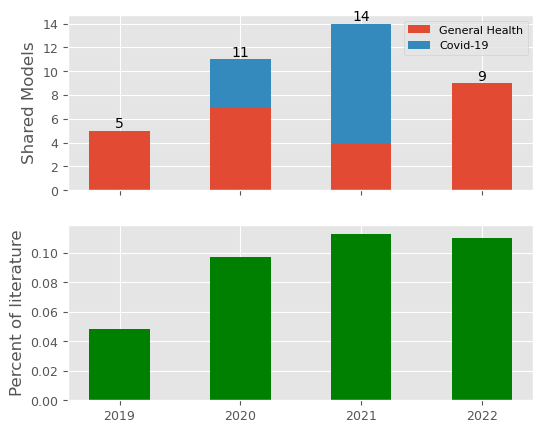

In [12]:
fig, axs = plot_data_by_year(n_general_models=non_covid[:-1],
                             n_covid_models=year_summary.T['n_covid_avail'][:-1],
                             per_models=year_summary.T['per_avail'][:-1],
                             xlabels=year_summary.columns[:-1],
                             grid=False)

In [13]:
# Coding error in 2019 - fixed in new version of dataset.
clean[(clean['pub_yr']==2019) & (clean['covid'] == 1)]


,key,item_type,pub_yr,author,title,pub_title,doi,url,study_included,model_code_available,...,covid,sim_software,foss_sim,model_archive,model_repo,model_journal_supp,model_journal_supp,model_personal_org,model_platform,available_on_req
169,4AY7MQIP,conferencePaper,2019,"Bosch, P.",Mixed-Mode Pandemic Modeling,Proceedings - Winter Simulation Conference,10.1109/WSC40007.2019.9004801,https://www.scopus.com/inward/record.uri?eid=2...,1,0.0,...,1.0,Sage,1,NaN,GitHub,NaN,NaN,NaN,NaN,NaN


In [14]:
def plot_all_data_by_year(n_avail_general_models, n_avail_covid_models, 
                          per_models, n_not_general_models, n_not_covid_models,
                          xlabels, width=WIDTH, grid=True,
                          figsize=(6, 6)):
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize)

    # include x, y grid 
    if grid:
        ax1.grid(ls='--', axis='y')
        ax2.grid(ls='--', axis='y')
    
    # plot one: stacked bar chart.  general health + covid models
    y1 = ax1.bar(xlabels, n_not_general_models, 
                label='Closed General', width=width)

    y2 = ax1.bar(xlabels, n_not_covid_models,
                 label='Closed Covid-19', bottom=n_not_general_models, 
                 width=width)
    
    y3 = ax1.bar(xlabels, n_avail_general_models,
                 label='Open General', 
                 bottom=n_not_general_models+n_not_covid_models, width=width)

    y4 = ax1.bar(xlabels, n_avail_covid_models,
                 label='Open Covid-19', 
                 bottom=n_not_general_models+n_not_covid_models+
                 n_avail_general_models, width=width)

    _ = ax1.set_ylabel('Models')
    #_ = ax1.legend(ncols=4, loc='best', fontsize=8)
    _ = fig.legend(loc='upper left', ncol=2, bbox_to_anchor=(0.11, 1.0), 
                   fontsize=9)


    # include x, y grid 
    if grid:
        ax1.grid(ls='--', axis='y')
        ax2.grid(ls='--', axis='y')
        
    ax1.bar_label(y4)

    # set size of x, y ticks
    ax1.tick_params(axis='both', labelsize=9)
    ax2.tick_params(axis='both', labelsize=9)

    # plot 2: percentage available by year
    _ = ax2.bar(xlabels, per_models, label='All models', 
                width=width, color='green')

    _ = ax2.set_ylabel('Percent of literature')
    
    return fig, (ax1, ax2)

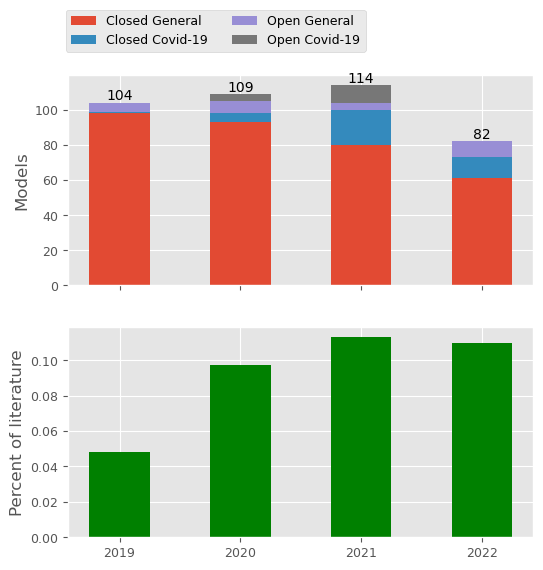

In [15]:
fig, axs = plot_all_data_by_year(n_avail_general_models=non_covid[:-1],
                                 n_avail_covid_models=year_summary.T['n_covid_avail'][:-1],
                             
                                 per_models=year_summary.T['per_avail'][:-1],
                                 n_not_general_models=n_not_avail_gen[:-1], 
                                 n_not_covid_models=n_not_avail_covid[:-1],
                                 xlabels=year_summary.columns[:-1],
                                 grid=False)